# Predictions for IFN T cell responses in healthy individuals infected with Mtb in a South African cohort. 

The authors used eleven representative Mtb antigens and a large panel of previously defined Mtb epitopes. 50– 75% of the total response in a cohort of 63 individuals. As expected, responses were highly heterogeneous, with responses to a total of 125 epitopes detected

Reference:

Lindestam Arlehamn, C.S. et al., 2016. A Quantitative Analysis of Complexity of Human Pathogen-Specific CD4 T Cell Responses in Healthy M. tuberculosis Infected South Africans. PLOS Pathogens, 12(7), p.e1005760. Available at: http://dx.plos.org/10.1371/journal.ppat.1005760.

In [125]:
import os, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 120)
pd.set_option('max_colwidth', 90)
%matplotlib inline
import matplotlib.pyplot as plt
import epitopepredict as ep
from epitopepredict import sequtils, analysis, base, tepitope, plotting, utilities
from IPython.display import display, HTML
import seaborn as sns
from importlib import reload
sns.set_style("ticks", {'axes.facecolor': 'white', 'axes.grid': False,
                        'legend.frameon':True, 'legend.fontsize':12})
sns.set_context("notebook", font_scale=1.4)

## get exp dataset

In [104]:
#sette mtb epitopes
sette = pd.read_csv('sette_SA_MTB_epitopes.csv')
sette.name.unique()
len(sette)

75

In [ ]:
proteins = sorted(sette.name.unique())
mtb = sequtils.genbank_to_dataframe(base.mtb_genome,cds=True)
mtb = mtb[mtb.locus_tag.isin(sette.name)]

df = pd.merge(sette, mtb[['locus_tag','translation']],left_on='name',right_on='locus_tag')
df['start'] = df.apply( lambda x: x.translation.find(x.sequence), 1 )
df['end'] = df.start+df.sequence.str.len()
#for i,r in df[df.start==-1].iterrows():
#    print (r.locus_tag, r.sequence, r.translation)
df=df.drop('translation',1)
df=df[df.start>=0]
prots = df.name.unique()
exp = df
print (df)

In [3]:
donoralleles = pd.read_csv('sa_mtb_donor_alleles.csv')
donoralleles = donoralleles.set_index('Donor ID')
donoralleles = donoralleles.apply(lambda x: 'HLA-'+x)
#print donoralleles

x = donoralleles.apply(lambda x : x.value_counts())
x = x.sum(1).sort_values(ascending=False)
x = x[x>=2]
drballeles = x[x.index.str.contains('DRB')]
drballeles = list(drballeles.index)
#print drballeles
dqalleles = x[x.index.str.contains('DQ')]
dqalleles = list(dqalleles.index)


## run predictions

In [83]:
Pt=ep.get_predictor('tepitope')
Pt.predict_sequences(mtb, alleles=drballeles,path='mtbsa_tepitope', length=15, overwrite=False, threads=10)
Pt.load(path='mtbsa_tepitope')
Pn=ep.get_predictor('netmhciipan')
Pn.predict_sequences(mtb, alleles=drballeles,path='mtbsa_netmhciipan', length=15, overwrite=False, threads=10)
Pn.load(path='mtbsa_netmhciipan')

predictions done for 29 sequences in 27 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/mtbsa_tepitope
took 447.051 seconds
predictions done for 29 sequences in 27 alleles
results saved to /home/damien/gitprojects/epitopepredict/examples/mtbsa_netmhciipan


In [157]:
print (len(Pn.data)/27)
print (Pn.data.allele.value_counts()[0])
print (len(Pn.data.allele.unique()))
print (Pn.data.allele.unique())

9299.0
9299
27
['HLA-DRB3*0202' 'HLA-DRB4*0101' 'HLA-DRB3*0101' 'HLA-DRB4*0103'
 'HLA-DRB1*0401' 'HLA-DRB1*0301' 'HLA-DRB5*0101' 'HLA-DRB1*0701'
 'HLA-DRB3*0301' 'HLA-DRB1*1301' 'HLA-DRB1*1503' 'HLA-DRB1*0302'
 'HLA-DRB1*1101' 'HLA-DRB1*1201' 'HLA-DRB1*0101' 'HLA-DRB1*0404'
 'HLA-DRB1*0405' 'HLA-DRB1*1501' 'HLA-DRB1*1502' 'HLA-DRB1*1202'
 'HLA-DRB1*1303' 'HLA-DRB1*1404' 'HLA-DRB1*1302' 'HLA-DRB1*0102'
 'HLA-DRB5*0102' 'HLA-DRB1*1114' 'HLA-DRB1*1102']


In [ ]:
print (proteins)
ax = plotting.plot_tracks([Pn,Pt],name='Rv1196',
                     n=5, cutoff=10, kind='tracks',                   
                     legend=True, cutoff_method='rank',            
                     figsize=(14,10))


## overlap of top ranking binders

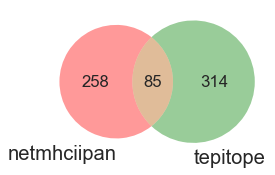

In [84]:
bn = Pn.get_binders(cutoff=5,cutoff_method='rank',limit=20)#, name='Rv3875')
bt = Pt.get_binders(cutoff=5,cutoff_method='rank',limit=20)#, name='Rv3875')
ax = utilities.venndiagram([bn.peptide,bt.peptide], ['netmhciipan','tepitope'])

## overlap of promiscuous binders

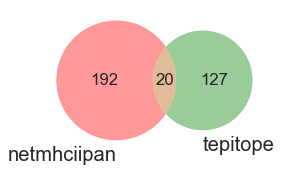

In [85]:
pbn = Pn.promiscuous_binders(n=5, cutoff=10, cutoff_method='rank')
pbt = Pt.promiscuous_binders(n=5, cutoff=10, cutoff_method='rank')
ax = utilities.venndiagram([pbn.peptide,pbt.peptide], ['netmhciipan','tepitope'])

## find percentage coverage at given cutoff levels

In [ ]:
import difflib

def get_hits(P,n,m,cutoffs):

    res = []
    print (cutoffs)
    for c in cutoffs:
        rb = P.promiscuous_binders(cutoff_method=m,cutoff=c,n=n,limit=30)
        #print (len(rbn),len(rbt),len(rboth))
        df=exp#[exp.name==name].copy()
        def find_matches(x, p):
            return len(difflib.get_close_matches(x.sequence, p, n=10, cutoff=.6))

        df.loc[:,'hits'] = df.apply(lambda x: find_matches(x, rb.peptide),1)        
        f = len(df[df.hits>0])/len(df)*100
        #print (df[:10])
        res.append({'cutoff':c,'binders':len(rb),m:f})
    res = pd.DataFrame(res)
    return res

print (len(proteins))
n=5
res = get_hits(Pn,n,'rank',cuts['rank'])
ax=res.plot(x='binders',y=['rank'],lw=2)
plt.tight_layout()

range(2, 40, 3)
range(50, 1000, 100)
[0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88 0.87]
range(2, 40, 3)
[5.  4.6 4.2 3.8 3.4 3.  2.6 2.2 1.8 1.4 1.  0.6 0.2]
[0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88 0.87]


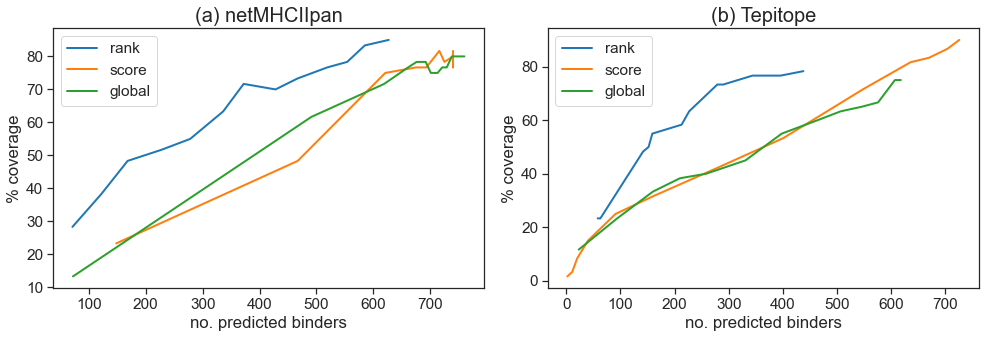

In [175]:
cuts = {'rank':range(2,40,3),'global':np.arange(.99,.86,-.01),'score':range(50,1000,100)}

fig,axs=plt.subplots(1,2,figsize=(14,5),facecolor='white')
axs=axs.flat
i=0
['rank','global','score']
for P in [Pn,Pt]:    
    res1 = get_hits(P,5,'rank',cuts['rank'])
    if P.name=='tepitope':
        scuts = np.arange(5,0,-.4)
    else:
        scuts=cuts['score']    
    res2 = get_hits(P,5,'score',scuts)
    res3 = get_hits(P,5,'global',cuts['global'])
    
    res1.plot(x='binders',y='rank',lw=2,ax=axs[i])
    res2.plot(x='binders',y='score',lw=2,ax=axs[i])
    res3.plot(x='binders',y='global',lw=2,ax=axs[i])    
    axs[i].set_xlabel('no. predicted binders')
    axs[i].set_ylabel('% coverage')    
    i+=1

axs[0].set_title('(a) netMHCIIpan',fontsize=20)
axs[1].set_title('(b) Tepitope',fontsize=20)
plt.tight_layout()
fig.savefig('mtb_sette_hits.png',dpi=300)

In [ ]:
p=Pn.promiscuous_binders(cutoff_method='score',cutoff=500,n=5)
p.name.value_counts()